In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

In [2]:
# takes a vector of x-locations and a vector of y-locations 
# and calculates the slope (dy/dx) at each x-location.
def slope(y, x):
    l = np.size(y)
    s = np.zeros(l)
    s[0] = (y[1]-y[0])/(x[1]-x[0])
    s[l-1] = (y[l-1]-y[l-2])/(x[l-1]-x[l-2])
    for i in range(1, l-1, 1):
        s[i] = (y[i+1]-y[i-1])/(x[i+1]-x[i-1])
    return s

In [3]:
# calculates curl of a vector F on a 2D rectangular grid
def curl(x, y, Fx, Fy):
    dFy_dx = np.zeros( (len(y), len(x)) )
    dFx_dy = np.zeros( (len(y), len(x)))

    for iy in range(len(y)):
        dFy_dx[iy,:] = slope( np.ravel(Fy[iy,:]), x )

    for ix in range(len(x)):
        dFx_dy[:,ix] = slope( np.ravel(Fx[:,ix]), y )

    return dFy_dx - dFx_dy

In [4]:
# importing data from NetCDF file, lats and lons are longitudes and latitudes
# vx_s is the eastward velocity, vy_s is the northward velocity
# 0<=t<31 specifies date, where t=0 is 2019-09-18, and t=30 is 2019-10-18 
def get_data(t):
    fname = '/home/moe/Projects/oceanography/global-analysis-forecast-phy-001-024_1570601365448.nc'
    ds = xr.open_dataset(fname)

    d, time = ds.depth, ds.time
    lat, long = ds.latitude, ds.longitude 
    v_x, v_y = ds.uo, ds.vo

    lats, lons = lat.values, long.values
    vx, vy = v_x.values, v_y.values
    
    w = np.shape(vx[0,:])[1]
    h = np.shape(vx[0,:])[2]
    w, h = np.shape(vx[0,:])[1], np.shape(vx[0,:])[2]
    vx_s, vy_s = vx[t,:].reshape((w,h)), vy[t,:].reshape((w,h))
    
    return lons, lats, vx_s, vy_s, time[t].values


In [5]:
def plot_data(t):
    lons, lats, vx_s, vy_s, time = get_data(t)
    vor = curl(lons, lats, vx_s, vy_s)   # calculating vorticity
    skip = 4 # skips data points when plotting vector field for better visualisation

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(
        central_longitude=0.0, globe=None)})
    fig.set_size_inches([16,8])

    ax.set_global()
    ax.stock_img()
    ax.coastlines(linewidth=0.5)

    plt.contourf(lons, lats, vor, levels=np.linspace(-13,13,99),  transform=ccrs.PlateCarree())
    cbar = plt.colorbar();
    cbar.ax.set_ylabel('Vorticity', rotation=270)
    ax.quiver(lons[::skip], lats[::skip], vx_s[::skip, ::skip], vy_s[::skip, ::skip],
              transform=ccrs.PlateCarree())
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
    plt.title(str(time)[0:10])
    plt.savefig('gulf_of_mexico'+' '+ str(t)+'.png')

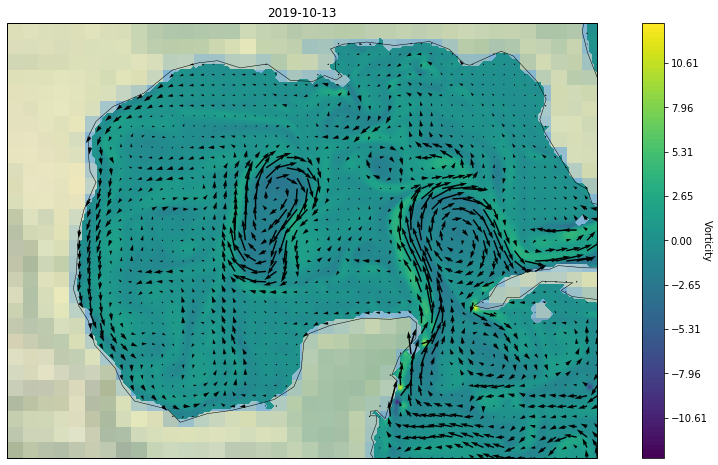

In [6]:
plot_data(25)